In [16]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import numpy as np

In [17]:
# Function to parse the flow info log
def parse_flow_info_log(flow_info_file):
    flows = {}
    with open(flow_info_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            flow_id = int(parts[0])
            flows[flow_id] = {
                'start_time': int(parts[6]),
                'end_time': int(parts[6]) + int(parts[7]),  # end_time = start_time + fct
                'links': set()
            }
    return flows

# Function to parse the link info log
def parse_link_info_log(link_info_file):
    link_flows = defaultdict(set)
    with open(link_info_file, 'r') as file:
        num_links = int(file.readline().strip())
        for _ in range(num_links):
            link_info = list(map(int, file.readline().strip().split(',')))
            flow_ids = list(map(int, file.readline().strip().split(',')[:-1]))
            assert link_info[3] == len(flow_ids)
            link = (link_info[1], link_info[2])
            link_flows[link].update(flow_ids)
    return link_flows

# Optimized function to assign links to flows
def assign_links_to_flows(flows, link_flows):
    for link, flow_ids in link_flows.items():
        for flow_id in flow_ids:
            if flow_id in flows:
                flows[flow_id]['links'].add(link)
    return flows

# Function to update bipartite graph and calculate busy periods
def update_bipartite_graph_and_calculate_busy_periods(flows):
    active_graphs = {}  # Dictionary to hold multiple bipartite graphs with graph_id as key
    busy_periods = []  # List to store busy periods
    events = []

    # Precompute events
    for flow_id, flow in flows.items():
        events.append((flow['start_time'], 'start', flow_id, flow['links']))
        events.append((flow['end_time'], 'end', flow_id, flow['links']))

    events.sort()

    link_to_graph = {}  # Map to quickly find which graph a link belongs to
    graph_id_new = 0  # Unique identifier for each graph

    for time, event, flow_id, links in events:
        if flow_id % 1000 == 0:
            print(f'Processing flow {flow_id}')
        if event == 'start':
            # Find all graphs involved with the new flow's links
            involved_graph_ids = set()
            for link in links:
                if link in link_to_graph:
                    involved_graph_ids.add(link_to_graph[link])

            new_active_links = defaultdict(set)
            new_all_links = set()
            new_flows = set()
            new_all_flows = set()
            
            if involved_graph_ids:
                for gid in involved_graph_ids:
                    graph = active_graphs.pop(gid)
                    new_active_links.update(graph['active_links'])
                    new_all_links.update(graph['all_links'])
                    new_flows.update(graph['active_flows'])
                    new_all_flows.update(graph['all_flows'])
                    time = graph['start_time']
                    
                    for link in graph['active_links']:
                        link_to_graph[link] = graph_id_new
            
            for link in links:
                new_active_links[link].add(flow_id)
                new_all_links.add(link)
                link_to_graph[link] = graph_id_new
            new_flows.add(flow_id)
            new_all_flows.add(flow_id)
            active_graphs[graph_id_new] = {
                'active_links': new_active_links,
                'all_links': new_all_links,
                'active_flows': new_flows,
                'all_flows': new_all_flows,
                'start_time': time
            }
            graph_id_new += 1

        elif event == 'end':
            graph = None
            for link in links:
                if link in link_to_graph:
                    graph_id = link_to_graph[link]
                    graph = active_graphs[graph_id]
                    break

            if graph:
                for link in links:
                    if flow_id in graph['active_links'][link]:
                        graph['active_links'][link].remove(flow_id)
                        if not graph['active_links'][link]:
                            del graph['active_links'][link]
                            if link in link_to_graph:
                                del link_to_graph[link]
                    else:
                        assert False, f"Flow {flow_id} not found in link {link} of graph {graph_id}"
                if flow_id in graph['active_flows']:
                    graph['active_flows'].remove(flow_id)
                else:
                    assert False, f"Flow {flow_id} not found in active flows of graph {graph_id}"
                if not graph['active_flows']:  # If no active flows left in the graph
                    busy_periods.append((graph['start_time'], time, list(graph['all_links']), list(graph['all_flows'])))
                    del active_graphs[graph_id]
                    for link in graph['active_links']:
                        if link in link_to_graph:
                            del link_to_graph[link]
            else:
                assert False, f"Flow {flow_id} has no active graph"
    return busy_periods

# Function to save results to a file
def save_results(filename, busy_periods):
    with open(filename, 'w') as file:
        json.dump(busy_periods, file)

# Function to read results from a file
def read_results(filename):
    with open(filename, 'r') as file:
        return json.load(file)

In [11]:
# Function to plot the CDF
def plot_cdf(data, xlabel, ylabel, title):
    data_sorted = np.sort(data)
    cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
    plt.plot(data_sorted, cdf, marker='.', linestyle='none')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Function to plot the relationship between number of flows and number of links
def plot_relationship(x_data, y_data, xlabel, ylabel, title):
    plt.scatter(x_data, y_data, alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Function to plot the number of busy periods over time
def plot_busy_periods_over_time(busy_periods):
    events = []

    for start_time, end_time, links, all_flows in busy_periods:
        events.append((start_time, 'start'))
        events.append((end_time, 'end'))

    events.sort()
    busy_count = 0
    times = []
    counts = []

    for time, event in events:
        if event == 'start':
            busy_count += 1
        elif event == 'end':
            busy_count -= 1
        times.append(time)
        counts.append(busy_count)

    plt.figure(figsize=(12, 6))
    plt.plot(times, counts, drawstyle='steps-post')
    plt.xlabel('Time')
    plt.ylabel('Number of Busy Periods')
    plt.title('Number of Busy Periods Over Time')
    plt.grid(True)
    plt.show()

Parsed 199997 flows
Parsed 704 links
Processing flow 0
Processing flow 0
Processing flow 1000
Processing flow 1000
Processing flow 2000
Processing flow 2000
Processing flow 3000
Processing flow 3000
Processing flow 4000
Processing flow 4000
Processing flow 5000
Processing flow 5000
Processing flow 6000
Processing flow 6000
Processing flow 7000
Processing flow 7000
Processing flow 8000
Processing flow 8000
Processing flow 9000
Processing flow 9000
Processing flow 10000
Processing flow 10000
Processing flow 11000
Processing flow 11000
Processing flow 12000
Processing flow 12000
Processing flow 13000
Processing flow 13000
Processing flow 14000
Processing flow 14000
Processing flow 15000
Processing flow 15000
Processing flow 16000
Processing flow 16000
Processing flow 17000
Processing flow 17000
Processing flow 18000
Processing flow 18000
Processing flow 19000
Processing flow 19000
Processing flow 20000
Processing flow 20000
Processing flow 21000
Processing flow 21000
Processing flow 22000

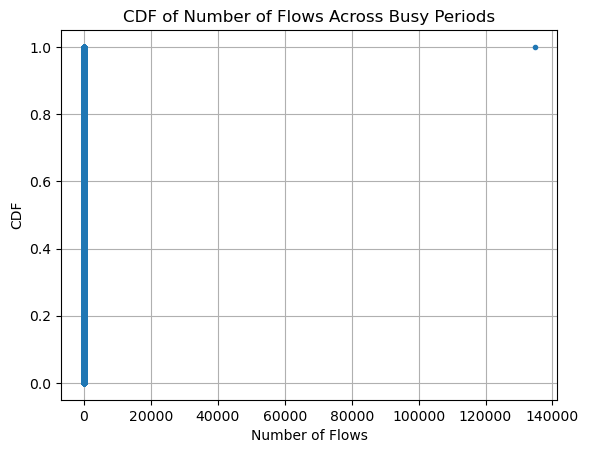

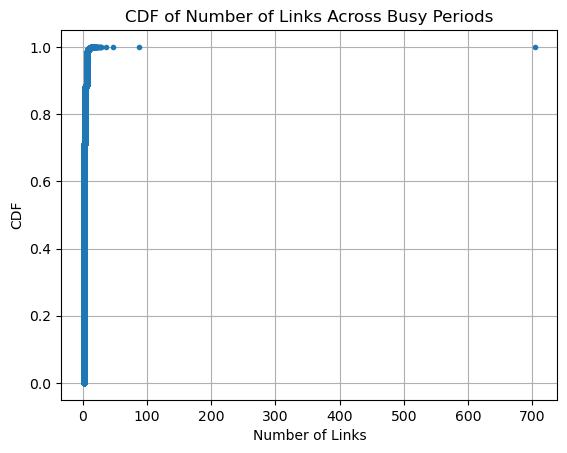

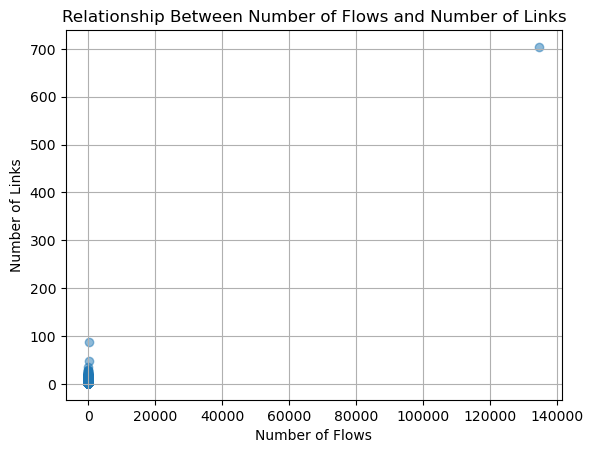

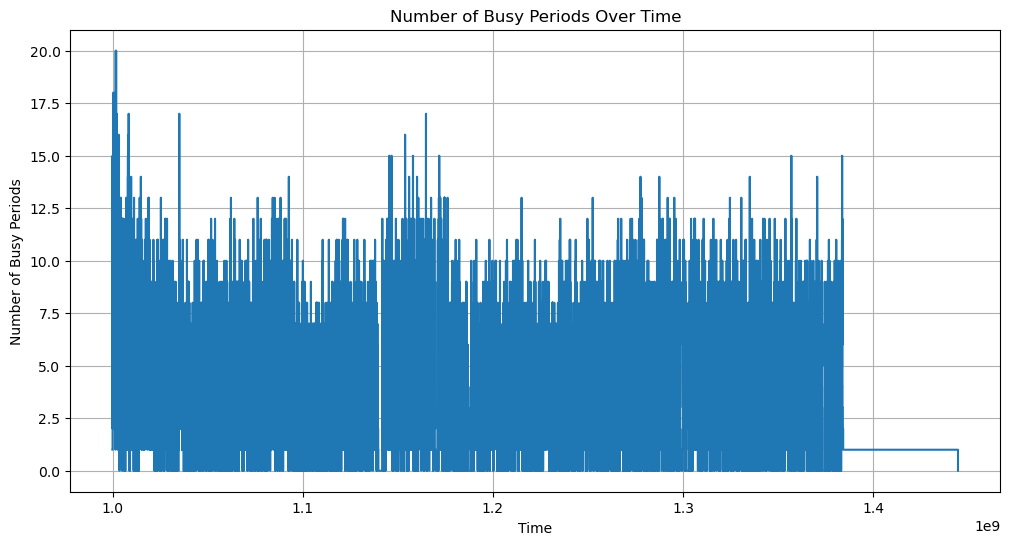

In [19]:
root_dir = '../data_test/'  # Update with the path to your root directory
# mix_list = [12, 20, 179]
mix_list = [12]
for mix_id in mix_list:
    flow_info_file = f"{root_dir}{mix_id}/ns3-config/0/fct_topology_flows_dctcp.txt"
    link_info_file = f"{root_dir}{mix_id}/mlsys-test/path_0.txt"
    result_file = f"./res/busy_periods_{mix_id}.json"

    # Parse logs
    if os.path.exists(result_file):
        busy_periods = read_results(result_file)
    else:
        flows = parse_flow_info_log(flow_info_file)
        print(f'Parsed {len(flows)} flows')
        link_flows = parse_link_info_log(link_info_file)
        print(f'Parsed {len(link_flows)} links')
        
        # Assign links to flows
        flows = assign_links_to_flows(flows, link_flows)
        
        # Update bipartite graph and calculate busy periods
        busy_periods = update_bipartite_graph_and_calculate_busy_periods(flows)
        
        # Save results
        save_results(result_file, busy_periods)
        print(f'Saved results to {result_file}')
    print(f'Found {len(busy_periods)} busy periods')
    # Plot CDF of number of flows across busy periods
    num_flows = [len(period[3]) for period in busy_periods]
    print(f"sum of number of flows: {sum(num_flows)}")
    print(f"max number of flows: {max(num_flows)} with index {num_flows.index(max(num_flows))}")
    plot_cdf(num_flows, 'Number of Flows', 'CDF', 'CDF of Number of Flows Across Busy Periods')
    
    # Plot CDF of number of links across busy periods
    num_links = [len(period[2]) for period in busy_periods]
    plot_cdf(num_links, 'Number of Links', 'CDF', 'CDF of Number of Links Across Busy Periods')
    
    # Plot the relationship between number of flows and number of links
    plot_relationship(num_flows, num_links, 'Number of Flows', 'Number of Links', 'Relationship Between Number of Flows and Number of Links')
    
    # Plot the number of busy periods over time
    plot_busy_periods_over_time(busy_periods)